# From Sparse to Dense representations of text

## Sparse representation of text: One-hot vectors

Traditionally we use a one-hot vectors to represent text as vectors. For example, for a sentence "a quick brown fox", we could end up with following one hot vectors.

    [1, 0, 0, 0] - a
    [0, 1, 0, 0] - quick
    [0, 0, 1, 1] - brown
    [0, 0, 0, 1] - fox
    
It's easy to see that for larger vocabularies such as web pages, faq articles, etc. i.e. the kind we typically see in IR settings, these vectors will be very long and very sparse with the dimensionality equal to the vocab size.

These vectors also have no information about the words they represent. For example, here "quick" is as similar to "fox" as it is to the word "brown".

** Vocab size refers to the number of unique tokens/terms used in a collection of documents.

## Distributional Semantics

Formally, dense representation of text is easy to define

$$ f(text) => \!R^n $$

In the above example, if we take n = 5, our dense vectors might look like

    [0.98, -1.12, 0.21, 0.01] - a
    [1.22, 2.12, -3.12, 3.11] - quick
    [-1.23, 4.30, 1.16, 0.90] - brown
    [0.11, 0.12, -1.23, 4.65] - fox

To capture the meaning of words in such dense vectors, we need to consider the notion of context for words in a piece of text. For example, consider these texts:

    1. A bottle of ________ is on the table.
    2. Everyone likes ________.
    3. ________ makes you drunk.
    4. We make ________ out of corn.

Now consider the word that could appear in the blank position. Given the context, we can guess it's an alcoholic beverage (the correct answer is `tezguino` btw).
Other alcoholic drinks made of corn also qualify here. The idea is that we can guess the word based on the it's surrounding words or the context in which it appears.

Techniques like word2vec, LSTMs, transformers build on top of this idea.

## Before Transformers

### Count based methods

The general process of creating dense represenations using count based methods is to:
 1. Create a word-context matrix.
 2. Reduce it's dimensionality.

We reduce dimensionality because of the large vocab size as well as the sparsity of such matrices(most of the terms are 0 in the matrix).
One such technique is LSA(Latent Semantic Analysis) which does SVD on the term document matrix(could be TF_IDF).

![](assets/lsa.jpg)
<br>
<center>(Source: https://www.frontiersin.org/articles/10.3389/fphys.2013.00008/full)</center>
<br>

### Word2Vec

Word2Vec works on the similar premise of encoding contextual information into the dense representation for a word.
Word2Vec wors in an iterative manner:
 - Start with a huge text corpus.
 - Go over the text using a sliding window. At each step, take a center word i and the context words(within the window).
 - For the center word, compute probabilites for all the words in the vocab using softmax.
 - Computer cross entropy loss for the context words and backprop over the embeddings to refine them.

![](assets/w2v_window.png)

There are two methods used to create the word embeddings:
 - CBOW(Continuous bag of words): Uses the context words to predict the center word.
 - Skip gram: Uses the center word to predict the context words.

![](assets/w2v.png)
<br>
<center>(Source: https://www.researchgate.net/figure/CBOW-and-Skip-Gram-neural-architectures_fig14_325651523)</center>
<br>

The ojective function is formulated as

$$ J(\theta) = - \frac{1}{T} \sum_{t=1}^T \sum_{-m<=j<=m, j\neq0} P(w_{t+j}|w_t,\theta) $$

<center>𝑃(𝑤𝑡+𝑗|𝑤𝑡,𝜃) - Probability of the context word given center word(skip gram)</center>

Essentially we are going over the whole text using a sliding window and computing the loss using the probability from softmax.

Some of the drawbacks of Wor2Vec:
 - Essentially a bag of words technique as we don't consider the order in which the words appear in a window.
 - Limited window size makes the learned representaions very limited in the sense that they only capture very local contexts.
 - We can't capture multiple embeddings for the same word in different context, for example, "a river bank", "bank deposit". The word "bank" ends with a single embedding even though it means two different things here.
 - Out of vocab words are not handeled.

There are methods to deal with some of these issues, like subword embeddings using fastText can handle out of vocab words. In general these bag of wordd techniques have fallen out of favor for methods we are going to discuss next.

### Recurrent Neural Nets

Before Transformers, RNNs especially LSTMs were all the rage but they have also fallen out of favour because of the following drawbacks:
 - The temporal dependence in updating the hidden state(over the tokens) make then slow to train and not let us effeciently use the modern hardware for training(gpus).
 - Even though theoratically LSTMs can handle arbitrarily long sequences, in practice they suffer from vanishing gradient.
 - The biggest problem is the bottleneck at the end of the sequence where we are trying to store all the historical information from the sequence into one final hidden vector.

![](assets/lstm_bottleneck.png)
<br>
<center>(Source: https://www.researchgate.net/figure/Encoder-decoder-model-using-stacked-LSTMs-for-encoding-and-one-LSTM-layer-for-decoding_fig1_340443252)</center>
<br>

The attention mechanism on top of the LSTMs help us solve the final bottleneck issue but we still struggle with slow training times as discussed in the first point.

As Transformers have proven, we don't really need this recurrent mechanism, by adding positional information into each token embedding and doing self attention on top of it, we can learn powerful representations of text and use them for all the downstream NLP tasks.

## Transformers for IR

In [1]:
import datasets
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### -- Data

In [3]:
dataset = datasets.load_dataset('snli', split='train')
dataset = dataset.filter(lambda x: False if x["label"] == -1 else True)

len(dataset), dataset[0]

Using the latest cached version of the module from /home/utsav/.cache/huggingface/modules/datasets_modules/datasets/snli/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b (last modified on Thu Jul 21 14:15:05 2022) since it couldn't be found locally at snli., or remotely on the Hugging Face Hub.
Reusing dataset snli (/home/utsav/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Loading cached processed dataset at /home/utsav/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-0436d94218380653.arrow


(549367,
 {'premise': 'A person on a horse jumps over a broken down airplane.',
  'hypothesis': 'A person is training his horse for a competition.',
  'label': 1})

In [4]:
all_cols = ['label']

for part in ['premise', 'hypothesis']:
    dataset = dataset.map(
        lambda x: tokenizer(
            x[part], max_length=128, padding='max_length',
            truncation=True
        ), batched=True
    )
    for col in ['input_ids', 'attention_mask']:
        dataset = dataset.rename_column(
            col, part+'_'+col
        )
        all_cols.append(part+'_'+col)
print(all_cols)

Parameter 'function'=<function <lambda> at 0x7fa5b2b9eee0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/550 [00:00<?, ?ba/s]

  0%|          | 0/550 [00:00<?, ?ba/s]

['label', 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask']


In [5]:
dataset.set_format(type='torch', columns=all_cols)

train_ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
next(iter(train_dataloader))

{'label': tensor([2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1]),
 'premise_input_ids': tensor([[ 101, 1037, 2317,  ...,    0,    0,    0],
         [ 101, 2048, 3337,  ...,    0,    0,    0],
         [ 101, 2093, 2624,  ...,    0,    0,    0],
         ...,
         [ 101, 1037, 2450,  ...,    0,    0,    0],
         [ 101, 1037, 7215,  ...,    0,    0,    0],
         [ 101, 1037, 2316,  ...,    0,    0,    0]]),
 'premise_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'hypothesis_input_ids': tensor([[ 101, 2048, 6077,  ...,    0,    0,    0],
         [ 101, 2048, 3428,  ...,    0,    0,    0],
         [ 101, 2070, 2610,  ...,    0,    0,    0],
         ...,
         [ 101, 1996, 2450,  ...,    0,    0,    0],
         [ 101, 1037, 7215,  ...,    0,    0,    0],
         [ 101, 1996, 

### -- Model config

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
class Sbert(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.ffnn = torch.nn.Linear(768*3, 3)

    def mean_pool(self, token_embeds, attention_mask):
        in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
        pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
        return pool

    def forward(self, data):
        premise_input_ids = data["premise_input_ids"].to(device)
        premise_attention_mask = data["premise_attention_mask"].to(device)
        hypothesis_input_ids = data["hypothesis_input_ids"].to(device)
        hypothesis_attention_mask = data["hypothesis_attention_mask"].to(device)

        out_premise = self.bert_model(premise_input_ids, premise_attention_mask)
        out_hypothesis = self.bert_model(hypothesis_input_ids, hypothesis_attention_mask)
        premise_embeds = out_premise.last_hidden_state
        hypothesis_embeds = out_hypothesis.last_hidden_state

        pooled_premise_embeds = self.mean_pool(premise_embeds, premise_attention_mask)
        pooled_hypotheses_embeds = self.mean_pool(hypothesis_embeds, hypothesis_attention_mask)

        embeds =  torch.cat([pooled_premise_embeds, pooled_hypotheses_embeds,
                             torch.abs(pooled_premise_embeds - pooled_hypotheses_embeds)],
                            dim=-1)
        return self.ffnn(embeds)

In [9]:
model = Sbert()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
model = model.to(device)

### -- Helper methods

In [12]:
def get_train_step_fn(model, optimizer, scheduler, loss_fn):

    def train_step_fn(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(model, loss_fn):

    def val_step_fn(x, y):
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(dataloader, step_fn):
    mini_batch_losses = []

    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(device))
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"step {i}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [13]:
n_epochs = 1

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn)
        val_mini_batch_losses += val_mini_batch_losses
        val_losses.append(val_loss)

step 0, loss =  1.108
step 64, loss =  1.097
step 128, loss =  1.096
step 192, loss =  1.090
step 256, loss =  1.083
step 320, loss =  1.106
step 384, loss =  1.064
step 448, loss =  1.088
step 512, loss =  1.030
step 576, loss =  0.958
step 640, loss =  1.005
step 704, loss =  0.985
step 768, loss =  0.866
step 832, loss =  0.871
step 896, loss =  0.856
step 960, loss =  0.979
step 1024, loss =  1.030
step 1088, loss =  0.802
step 1152, loss =  1.035
step 1216, loss =  0.717
step 1280, loss =  0.901
step 1344, loss =  0.733
step 1408, loss =  0.776
step 1472, loss =  0.955
step 1536, loss =  1.006
step 1600, loss =  0.993
step 1664, loss =  1.092
step 1728, loss =  0.950
step 1792, loss =  0.476
step 1856, loss =  0.810
step 1920, loss =  0.608
step 1984, loss =  0.838
step 2048, loss =  0.673
step 2112, loss =  0.852
step 2176, loss =  0.925
step 2240, loss =  0.944
step 2304, loss =  0.601
step 2368, loss =  0.745
step 2432, loss =  0.529
step 2496, loss =  0.787
step 2560, loss =  

KeyboardInterrupt: 

In [157]:
sentences = [
    "What should I do to improve my English ?",
    "What should I do to improve my spoken English?",
    "Can I improve my English?",
    "How can I earn money online?",
    "How do I earn money online?",
    "Can I earn money online?",
    "What are some mind-blowing Mobile gadgets that exist that most people don't know about?",
    "What are some mind-blowing gadgets and technologies that exist that most people don't know about?",
    "What are some mind-blowing mobile technology tools that exist that most people don't know about?"
]

In [158]:
def plot_heatmap(similarity_matrix, sentences):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap='YlGn', interpolation='nearest')

    ax.set_yticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])
    ax.set_xticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(j, i, round(similarity_matrix[i, j], 2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

In [159]:
tokenized_texts = tokenizer(sentences, max_length=128, padding='max_length', truncation=True, return_tensors="pt")

In [160]:
token_embeds = model.bert_model(tokenized_texts["input_ids"].to(device),
                                tokenized_texts["attention_mask"].to(device)).last_hidden_state
pooled_emebds = model.mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))

In [161]:
pooled_emebds = pooled_emebds.cpu().detach().numpy()

In [162]:
from sklearn.metrics.pairwise import cosine_similarity

In [163]:
similarity_matrix = cosine_similarity(pooled_emebds)

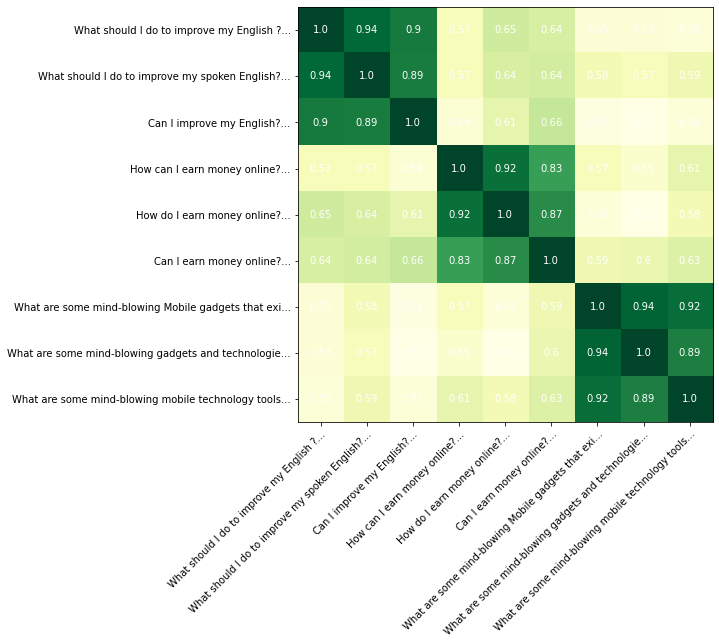

In [164]:
plot_heatmap(similarity_matrix, sentences)

In [165]:
import os

model_path = "./models/sbert_softmax"

if not os.path.exists(model_path):
    os.mkdir(model_path)

model.bert_model.save_pretrained(model_path)

In [166]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [167]:
token_embeds = bert_model(tokenized_texts["input_ids"],
                          tokenized_texts["attention_mask"]).last_hidden_state
pooled_emebds = model.mean_pool(token_embeds, tokenized_texts["attention_mask"])

In [168]:
pooled_emebds = pooled_emebds.detach().numpy()
similarity_matrix = cosine_similarity(pooled_emebds)

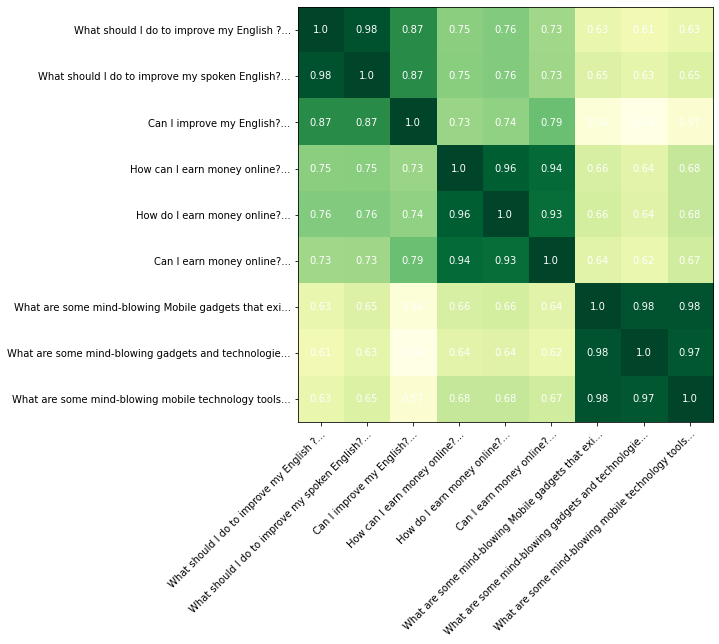

In [169]:
plot_heatmap(similarity_matrix, sentences)

---

## References

[1]. https://lena-voita.github.io/nlp_course/word_embeddings.html

[2]. https://www.pinecone.io/learn/train-sentence-transformers-softmax/